## NHS Adoption

In [ ]:

# Imports & Setup

from pathlib import Path
from copy import deepcopy
from datetime import datetime

import numpy as np
import pandas as pd

# Matplotlib for plots (optional)
try:
    import matplotlib.pyplot as plt
    MAKE_PLOTS = True
except Exception:
    MAKE_PLOTS = False

pd.set_option("display.max_columns", 100)

In [ ]:

# Basic Config


INPUT_CSV = "Adoption_new.csv" 

OUTDIR = Path("outputs")
OUTDIR.mkdir(parents=True, exist_ok=True)

# Timestamped filenames to avoid PermissionError if files are open in Excel
TS = datetime.now().strftime("%Y%m%d-%H%M%S")

# Forecast window (adoption modelling)
START_YEAR = 2025
HORIZON_YEARS = 8  # 2025..2032

# Adoption scenarios (logistic S-curve parameters) — base caps are absolute numbers
SCENARIOS = {
    "Pessimistic": {"K": 40,  "r": 0.8, "t0": 3.0},
    "Moderate":    {"K": 70,  "r": 1.0, "t0": 3.0},
    "Optimistic":  {"K": 100, "r": 1.2, "t0": 3.0},
}

In [ ]:

# ARI Weights
# (6-feature ARI, sums to 1.00)


# Baseline (primary)
WEIGHTS_BASELINE = {
    "scans":      0.30,  # Prostate MRI proxy (demand)
    "machines":   0.20,  # Capacity
    "past_ai":    0.20,  # Organisational readiness
    "wait_list":  0.15,  # Backlog pressure
    "wait_6w":    0.10,  # Bottleneck/stress
    "university": 0.05,  # Innovation orientation (lighter)
}

# Sensitivity sets
WEIGHT_SETS = {
    "baseline": WEIGHTS_BASELINE,
    "demand_tilt": {
        "scans": 0.25, "machines": 0.18, "past_ai": 0.17,
        "wait_list": 0.20, "wait_6w": 0.15, "university": 0.05,
    },
    "readiness_tilt": {
        "scans": 0.25, "machines": 0.25, "past_ai": 0.25,
        "wait_list": 0.15, "wait_6w": 0.05, "university": 0.05,
    },
    "balanced": {
        "scans": 0.25, "machines": 0.20, "past_ai": 0.20,
        "wait_list": 0.15, "wait_6w": 0.10, "university": 0.10,
    },
}
# Safety
for k, w in WEIGHT_SETS.items():
    s = round(sum(w.values()), 6)
    assert np.isclose(s, 1.0), f"Weight set '{k}' must sum to 1.0 (got {s})"


In [ ]:

# Helper functions


def robust_scale(series: pd.Series) -> pd.Series:
    """
    Robust scaling: (x - median) / IQR. Falls back to std or zeros if needed.
    """
    s = pd.to_numeric(series, errors="coerce")
    med = s.median()
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    if pd.notna(iqr) and iqr != 0:
        out = (s - med) / iqr
    else:
        std = s.std(ddof=0)
        out = (s - med) / std if (pd.notna(std) and std != 0) else pd.Series(0.0, index=s.index)
    return out.fillna(0.0)

def minmax_0_100(series: pd.Series) -> pd.Series:
    """Map to a 0–100 index with constant-series guard."""
    s = pd.to_numeric(series, errors="coerce").astype(float)
    lo, hi = s.min(), s.max()
    if not np.isfinite(lo) or not np.isfinite(hi) or hi == lo:
        return pd.Series(50.0, index=s.index)
    return 100.0 * (s - lo) / (hi - lo)

def logistic_cumulative_array(T: int, K: int, r: float, t0: float) -> np.ndarray:
    """cum(t) = K / (1 + exp(-r*(t - t0))) for t = 0..T-1"""
    t = np.arange(T, dtype=float)
    return K / (1.0 + np.exp(-r * (t - t0)))

In [ ]:

# Load & clean


df = pd.read_csv(INPUT_CSV)

# Expected columns
COL_PROVIDER   = "Provider name"
COL_UNIVERSITY = "University Hopsital (Yes-1/No-0)"   # 1/0
COL_PAST_AI    = "Past Adoption Of AI tools"          # Yes/No
COL_SCANS      = "No of MRI Prostate Scans(5% of total)"
COL_MACHINES   = "No of Machines"
COL_WAIT_LIST  = "Total Prostate MRI waiting List"
COL_WAIT_6W    = "Prostate MRI waiting 6+weeks"

# Basic numeric clean (only ARI-used columns)
for c in [COL_SCANS, COL_MACHINES, COL_WAIT_LIST, COL_WAIT_6W]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
        med = df[c].median()
        df[c] = df[c].fillna(med if pd.notna(med) else 0)

# University flag clean
if COL_UNIVERSITY in df.columns:
    df[COL_UNIVERSITY] = pd.to_numeric(df[COL_UNIVERSITY], errors="coerce").fillna(0).clip(0, 1)
else:
    df[COL_UNIVERSITY] = 0

# Past AI → binary
df["Past_AI_Adoption_Flag"] = (
    df.get(COL_PAST_AI, pd.Series(["no"] * len(df)))
      .astype(str).str.strip().str.lower()
      .map({"yes": 1, "no": 0}).fillna(0).astype(int)
)

# Preserve provider order aligned to df (used later to avoid label mismatch)
PROVIDERS = df[COL_PROVIDER].reset_index(drop=True)

In [ ]:

# Build scaled features (6 only)
# Directional assumption: higher backlog → higher readiness pressure


scaled = pd.DataFrame(index=df.index)
# Demand / pressure
scaled["scans_z"]      = robust_scale(df[COL_SCANS])      if COL_SCANS in df.columns else  pd.Series(0.0, index=df.index)
scaled["wait_list_z"]  = robust_scale(df[COL_WAIT_LIST])  if COL_WAIT_LIST in df.columns else pd.Series(0.0, index=df.index)
scaled["wait_6w_z"]    = robust_scale(df[COL_WAIT_6W])    if COL_WAIT_6W in df.columns else   pd.Series(0.0, index=df.index)
# Capacity / readiness
scaled["machines_z"]     = robust_scale(df[COL_MACHINES]) if COL_MACHINES in df.columns else pd.Series(0.0, index=df.index)
scaled["past_ai_bin"]    = df["Past_AI_Adoption_Flag"].astype(float)
scaled["university_bin"] = df[COL_UNIVERSITY].astype(float)

print("[INFO] Scaled feature columns:", list(scaled.columns))

[INFO] Scaled feature columns: ['scans_z', 'wait_list_z', 'wait_6w_z', 'machines_z', 'past_ai_bin', 'university_bin']


### ARI

In [ ]:

# ARI (Baseline ranking)


def compute_ari_from_weights(scaled_df: pd.DataFrame, weights: dict) -> pd.Series:
    return (
        weights["scans"]      * scaled_df["scans_z"] +
        weights["machines"]   * scaled_df["machines_z"] +
        weights["past_ai"]    * scaled_df["past_ai_bin"] +
        weights["wait_list"]  * scaled_df["wait_list_z"] +
        weights["wait_6w"]    * scaled_df["wait_6w_z"] +
        weights["university"] * scaled_df["university_bin"]
    )

# Baseline ARI
ari_raw_baseline = compute_ari_from_weights(scaled, WEIGHTS_BASELINE)
ari_score_baseline = minmax_0_100(ari_raw_baseline)

ranked = pd.DataFrame({
    "Provider": PROVIDERS,
    "ARI_Raw": ari_raw_baseline.round(6),
    "ARI_Score": ari_score_baseline.round(2),
    "UniversityHospital": df[COL_UNIVERSITY].astype(int),
    "PastAIAdoption": df["Past_AI_Adoption_Flag"].astype(int),
    "MRI_Prostate_Scans": df.get(COL_SCANS, np.nan),
    "MRI_Machines": df.get(COL_MACHINES, np.nan),
    "Waiting_List": df.get(COL_WAIT_LIST, np.nan),
    "Waiting_6w_plus": df.get(COL_WAIT_6W, np.nan),
}).sort_values(["ARI_Score", "ARI_Raw"], ascending=False).reset_index(drop=True)
ranked.insert(0, "Rank", np.arange(1, len(ranked) + 1))

ranked_path = OUTDIR / f"ari_scores_ranked_{TS}.csv"
ranked.to_csv(ranked_path, index=False)
display(ranked.head(15))
print(f"[SAVED] Baseline ARI ranking -> {ranked_path.resolve()}")

,Rank,Provider,ARI_Raw,ARI_Score,UniversityHospital,PastAIAdoption,MRI_Prostate_Scans,MRI_Machines,Waiting_List,Waiting_6w_plus
0,1,Guy's and St Thomas' NHS Foundation Trust,2.847626,100.00,0,1,4273,15,5280,2470
1,2,East Kent Hospitals University NHS Foundation ...,1.952435,74.26,1,1,4060,7,4885,1231
2,3,University Hospitals of Leicester NHS Trust,1.897828,72.69,1,0,3163,10,5153,1698
3,4,Barts Health NHS Trust,1.883900,72.29,0,1,3640,9,4302,1406
4,5,University Hospitals Birmingham NHS Foundation...,1.715214,67.44,1,1,4821,12,3150,211
5,6,Northern Care Alliance NHS Foundation Trust,1.684802,66.57,0,1,4526,14,3491,91
6,7,Nottingham University Hospitals NHS Trust,1.593100,63.93,1,1,3297,12,2768,930
7,8,Manchester University NHS Foundation Trust,1.572325,63.34,1,1,2986,8,3737,1179
8,9,Imperial College Healthcare NHS Trust,1.543602,62.51,0,1,4371,12,2618,350
9,10,University Hospitals Sussex NHS Foundation Trust,1.408948,58.64,1,1,3811,12,1942,443


[SAVED] Baseline ARI ranking -> C:\Users\PAVILION\OneDrive - Queen Mary, University of London\Quibim\FINAL_CODES\ADOPTION\outputs\ari_scores_ranked_20250821-125428.csv


In [ ]:

# Sensitivity: weight sets & diffusion variants
# (with alignment fix)


# Diffusion variants around SCENARIOS
SCENARIOS_VARIANTS = {
    "Baseline": deepcopy(SCENARIOS),

    "Faster": {
        "Pessimistic": {"K": SCENARIOS["Pessimistic"]["K"], "r": 1.1, "t0": 2.8},
        "Moderate":    {"K": SCENARIOS["Moderate"]["K"],    "r": 1.3, "t0": 2.8},
        "Optimistic":  {"K": SCENARIOS["Optimistic"]["K"],  "r": 1.5, "t0": 2.5},
    },

    "Slower": {
        "Pessimistic": {"K": SCENARIOS["Pessimistic"]["K"], "r": 0.6, "t0": 3.3},
        "Moderate":    {"K": SCENARIOS["Moderate"]["K"],    "r": 0.8, "t0": 3.3},
        "Optimistic":  {"K": SCENARIOS["Optimistic"]["K"],  "r": 1.0, "t0": 3.2},
    },

    "LowerCap": {
        "Pessimistic": {"K": max(1, int(0.25 * len(ranked))), "r": 0.8, "t0": 3.0},
        "Moderate":    {"K": max(1, int(0.50 * len(ranked))), "r": 1.0, "t0": 3.0},
        "Optimistic":  {"K": max(1, int(0.70 * len(ranked))), "r": 1.2, "t0": 3.0},
    },

    "HigherCap": {
        "Pessimistic": {"K": min(len(ranked), int(0.40 * len(ranked))), "r": 0.8, "t0": 3.0},
        "Moderate":    {"K": min(len(ranked), int(0.70 * len(ranked))), "r": 1.0, "t0": 3.0},
        "Optimistic":  {"K": min(len(ranked), int(0.95 * len(ranked))), "r": 1.2, "t0": 3.0},
    },
}

def rank_providers_for_weights(weights_name: str, weights: dict,
                               scaled_df: pd.DataFrame = scaled,
                               providers: pd.Series = PROVIDERS) -> pd.DataFrame:
    """
    Build ranking for a given weight set with correct label/score alignment.
    """
    assert len(scaled_df) == len(providers), "Mismatch: scaled_df and providers must have same length"
    ari_raw = compute_ari_from_weights(scaled_df, weights).reset_index(drop=True)
    out = pd.DataFrame({
        "Provider": providers.values,
        "ARI_Raw": ari_raw.round(6).values,
    })
    out["ARI_Score"] = minmax_0_100(out["ARI_Raw"]).round(2)
    out = out.sort_values(["ARI_Score", "ARI_Raw"], ascending=False).reset_index(drop=True)
    out.insert(0, "Rank", np.arange(1, len(out) + 1))
    out["Weights_Set"] = weights_name
    return out

def simulate_for_ranked(ranked_df: pd.DataFrame, scenarios: dict, scenario_variant_name: str):
    """
    Simulate adoption given a ranked table and a scenario dict.
    Returns (schedules_df, assignments_df).
    """
    years = list(range(START_YEAR, START_YEAR + HORIZON_YEARS))
    total = len(ranked_df)

    def scenario_curve(years, K, r, t0, cap):
        T = len(years)
        K_eff = min(int(K), int(cap))
        cum = logistic_cumulative_array(T, K_eff, r, t0)
        cum = np.clip(np.round(cum).astype(int), 0, cap)
        cum = np.maximum.accumulate(cum)
        cum[-1] = min(cum[-1], cap)
        new = np.diff(np.insert(cum, 0, 0))
        return cum, new

    schedules = []
    assignments = []

    for scen_name, p in scenarios.items():
        cum, new = scenario_curve(years, p["K"], p["r"], p["t0"], cap=total)
        df_sched = pd.DataFrame({"Year": years, "New_Adopters": new, "Cumulative_Adopters": cum})
        df_sched["Scenario"] = scen_name
        df_sched["Scenario_Variant"] = scenario_variant_name
        schedules.append(df_sched)

        rows = []
        cursor = 0
        for y, n in zip(years, new):
            if n <= 0:
                continue
            end = min(cursor + int(n), total)
            if end > cursor:
                batch = ranked_df.loc[cursor:end-1, ["Provider", "ARI_Score", "ARI_Raw"]].copy()
                batch["AdoptionYear"] = y
                batch["Scenario"] = scen_name
                batch["Scenario_Variant"] = scenario_variant_name
                rows.append(batch)
            cursor = end
            if cursor >= total:
                break

        assignments.append(pd.concat(rows, ignore_index=True) if rows else
                           pd.DataFrame(columns=["Provider","ARI_Score","ARI_Raw","AdoptionYear","Scenario","Scenario_Variant"]))

    return pd.concat(schedules, ignore_index=True), pd.concat(assignments, ignore_index=True)

# Run the sensitivity grid
all_rankings, all_schedules, all_assignments = [], [], []

for wname, w in WEIGHT_SETS.items():
    ranked_ws = rank_providers_for_weights(wname, w)
    all_rankings.append(ranked_ws.assign(Weights_Set=wname))

    for svar_name, scen_dict in SCENARIOS_VARIANTS.items():
        sched, assign = simulate_for_ranked(ranked_ws, scen_dict, svar_name)
        sched["Weights_Set"] = wname
        assign["Weights_Set"] = wname
        all_schedules.append(sched)
        all_assignments.append(assign)

rankings_all    = pd.concat(all_rankings, ignore_index=True)
schedules_all   = pd.concat(all_schedules, ignore_index=True)
assignments_all = pd.concat(all_assignments, ignore_index=True)

# Save (timestamped)
rankings_path    = OUTDIR / f"ari_sensitivity_rankings_{TS}.csv"
schedules_path   = OUTDIR / f"ari_sensitivity_schedules_{TS}.csv"
assignments_path = OUTDIR / f"ari_sensitivity_assignments_{TS}.csv"

rankings_all.to_csv(rankings_path, index=False)
schedules_all.to_csv(schedules_path, index=False)
assignments_all.to_csv(assignments_path, index=False)

print("[SAVED] Rankings   ->", rankings_path.resolve())
print("[SAVED] Schedules  ->", schedules_path.resolve())
print("[SAVED] Assignments->", assignments_path.resolve())

# Compact milestone summary
milestones = [START_YEAR + 1, START_YEAR + 3, START_YEAR + HORIZON_YEARS - 1]
summary_rows = []
for (wset, svar, scen), grp in schedules_all.groupby(["Weights_Set","Scenario_Variant","Scenario"]):
    row = {"Weights_Set": wset, "Scenario_Variant": svar, "Scenario": scen}
    for m in milestones:
        cm = grp.loc[grp["Year"] <= m, "Cumulative_Adopters"].max()
        row[f"Adopters_by_{m}"] = int(cm) if pd.notna(cm) else 0
    row["Adopters_by_end"] = int(grp["Cumulative_Adopters"].max())
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows).sort_values(
    ["Scenario_Variant", "Scenario", "Weights_Set"]
).reset_index(drop=True)

summary_path = OUTDIR / f"ari_sensitivity_summary_{TS}.csv"
summary_df.to_csv(summary_path, index=False)
print("[SAVED] Summary ->", summary_path.resolve())

from IPython.display import display
display(summary_df.head(12))


[SAVED] Rankings   -> C:\Users\PAVILION\OneDrive - Queen Mary, University of London\Quibim\FINAL_CODES\ADOPTION\outputs\ari_sensitivity_rankings_20250821-125428.csv
[SAVED] Schedules  -> C:\Users\PAVILION\OneDrive - Queen Mary, University of London\Quibim\FINAL_CODES\ADOPTION\outputs\ari_sensitivity_schedules_20250821-125428.csv
[SAVED] Assignments-> C:\Users\PAVILION\OneDrive - Queen Mary, University of London\Quibim\FINAL_CODES\ADOPTION\outputs\ari_sensitivity_assignments_20250821-125428.csv
[SAVED] Summary -> C:\Users\PAVILION\OneDrive - Queen Mary, University of London\Quibim\FINAL_CODES\ADOPTION\outputs\ari_sensitivity_summary_20250821-125428.csv


,Weights_Set,Scenario_Variant,Scenario,Adopters_by_2026,Adopters_by_2028,Adopters_by_2032,Adopters_by_end
0,balanced,Baseline,Moderate,8,35,69,69
1,baseline,Baseline,Moderate,8,35,69,69
2,demand_tilt,Baseline,Moderate,8,35,69,69
3,readiness_tilt,Baseline,Moderate,8,35,69,69
4,balanced,Baseline,Optimistic,8,50,99,99
5,baseline,Baseline,Optimistic,8,50,99,99
6,demand_tilt,Baseline,Optimistic,8,50,99,99
7,readiness_tilt,Baseline,Optimistic,8,50,99,99
8,balanced,Baseline,Pessimistic,7,20,38,38
9,baseline,Baseline,Pessimistic,7,20,38,38


### Adoption Plots

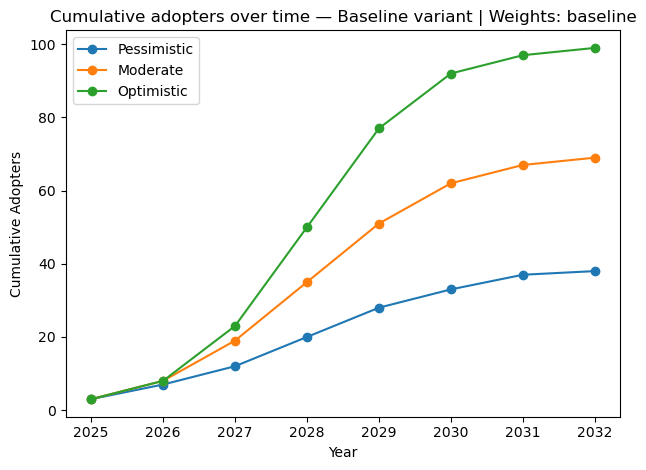

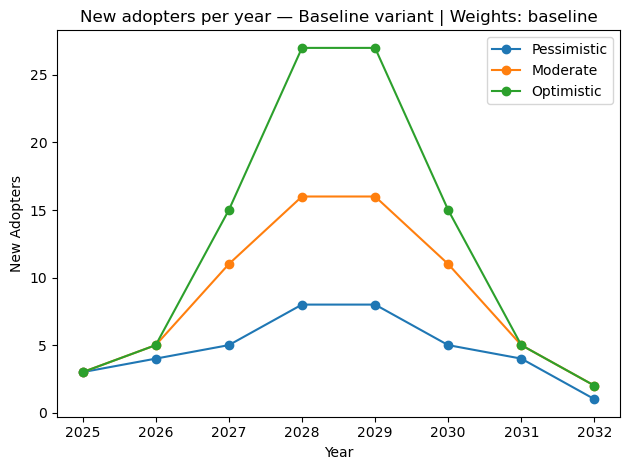

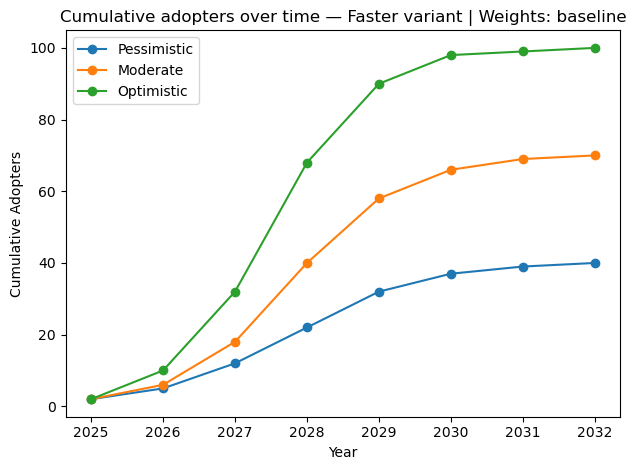

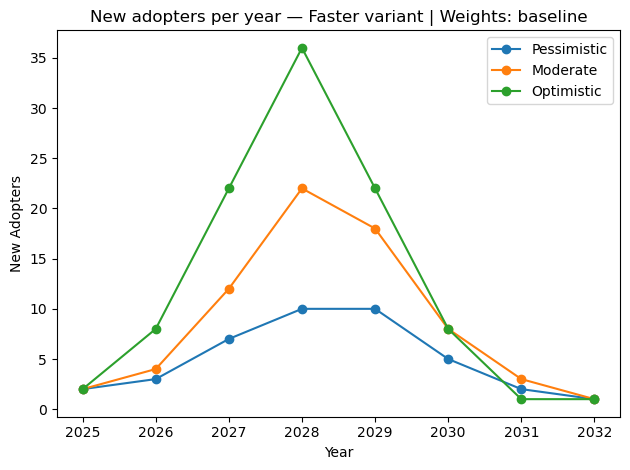

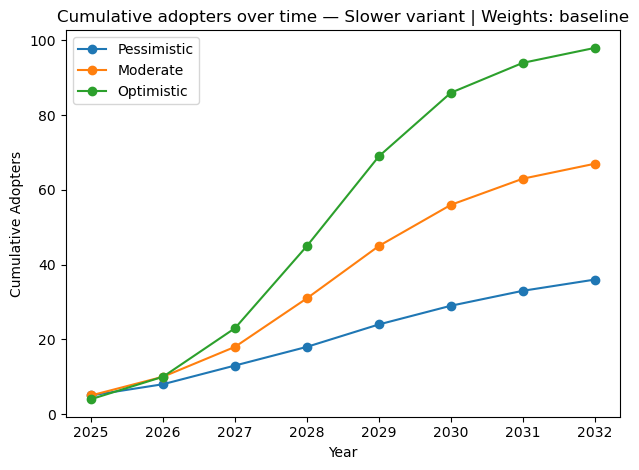

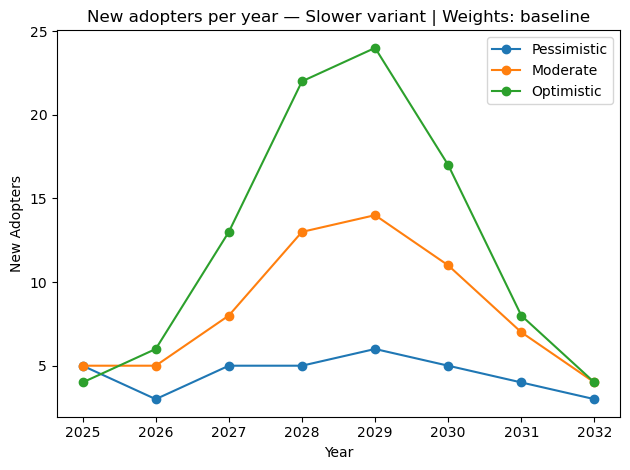

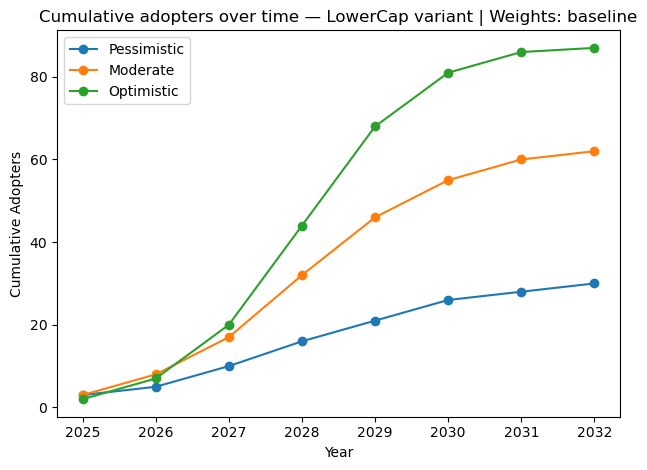

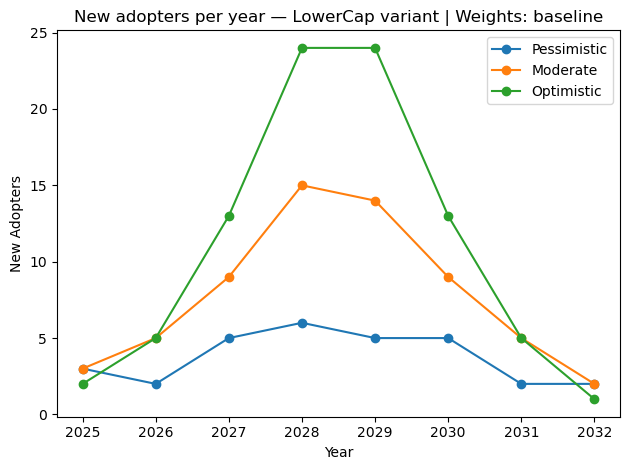

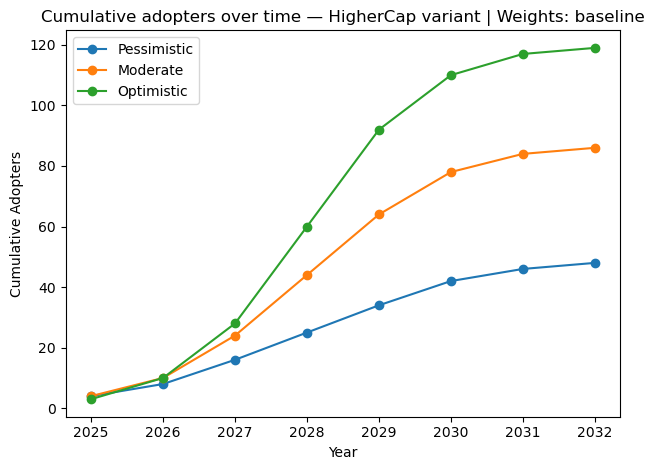

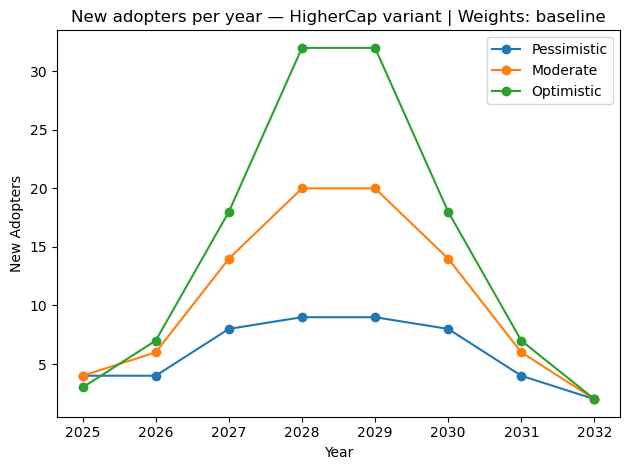

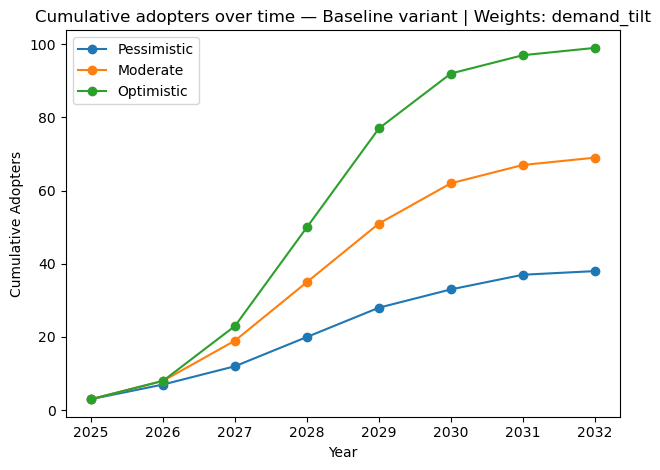

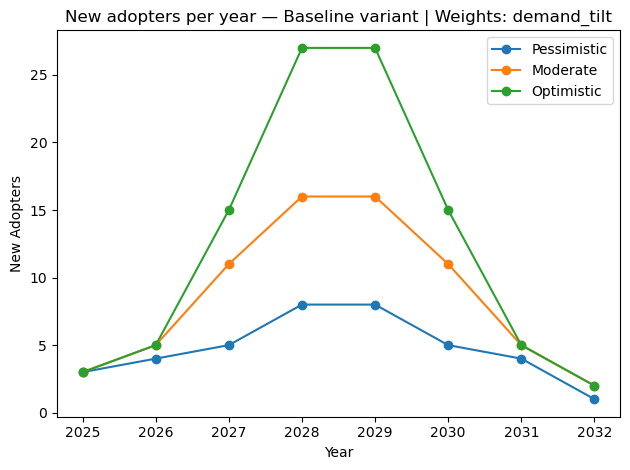

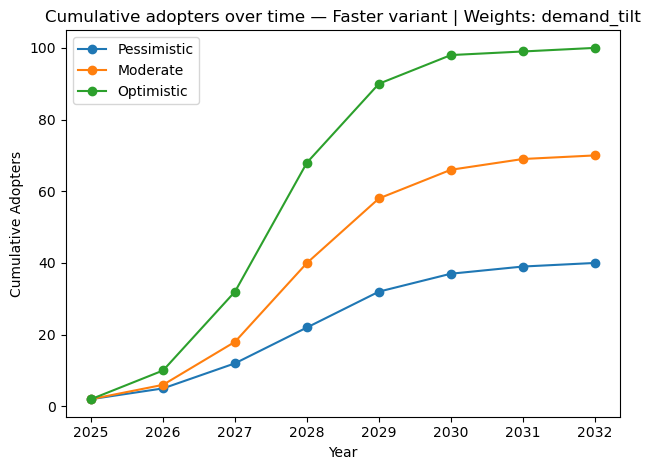

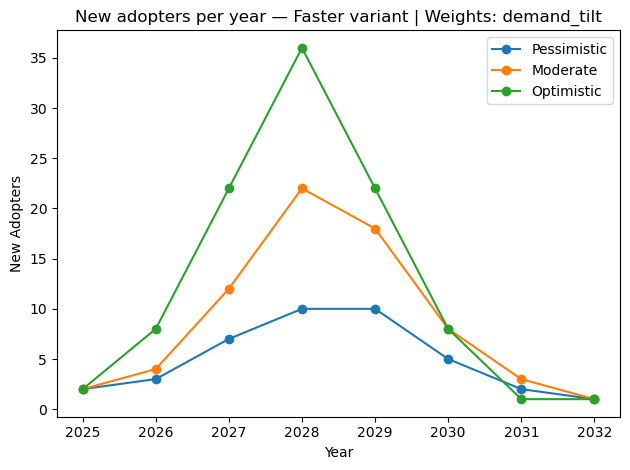

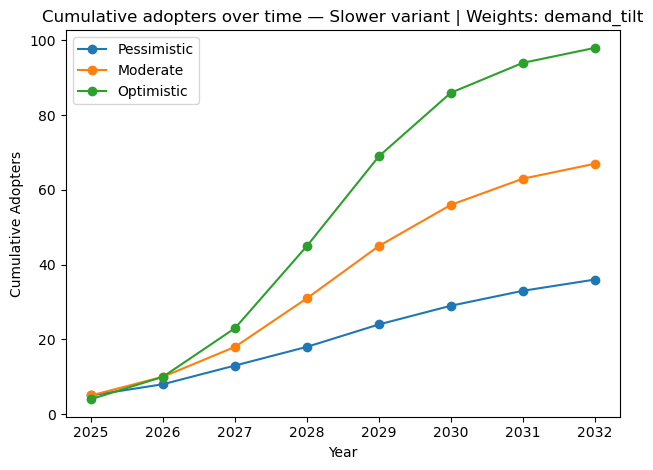

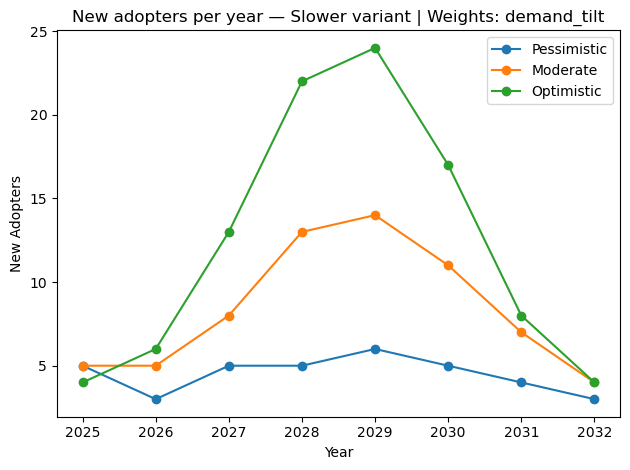

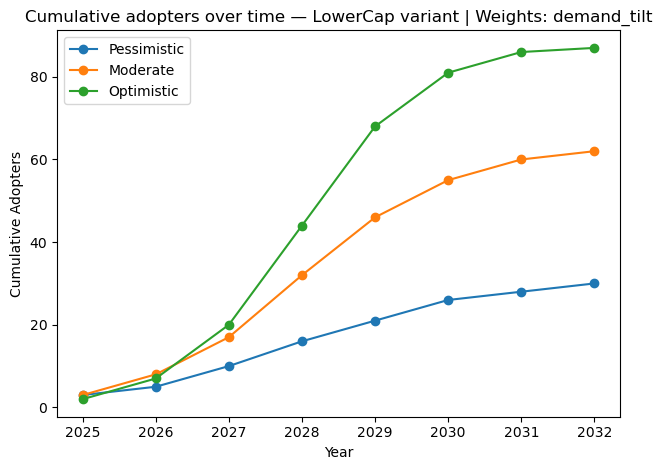

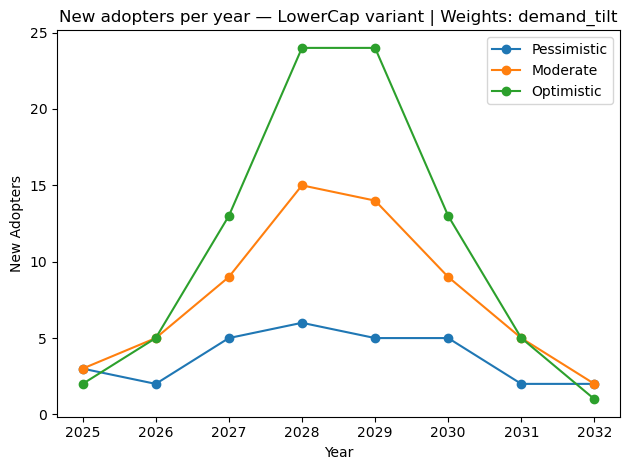

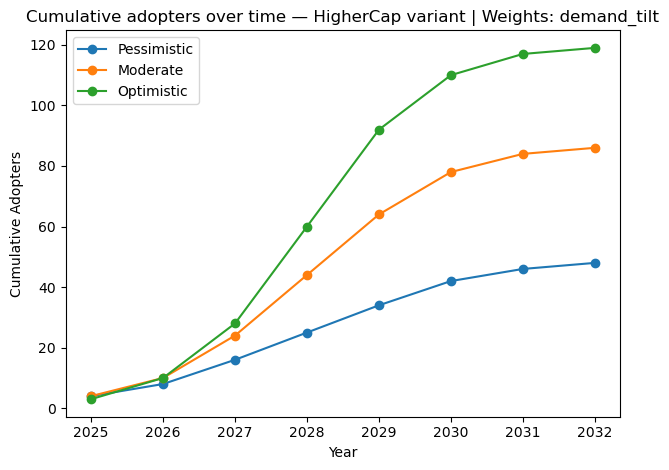

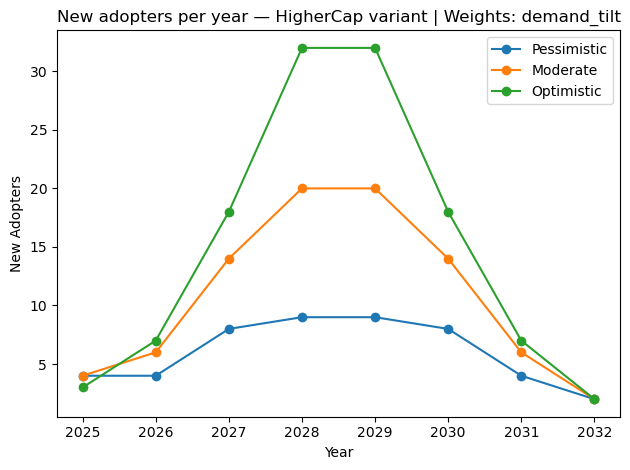

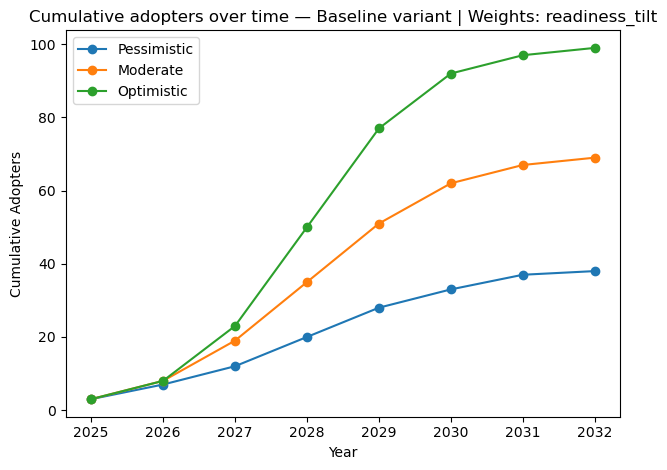

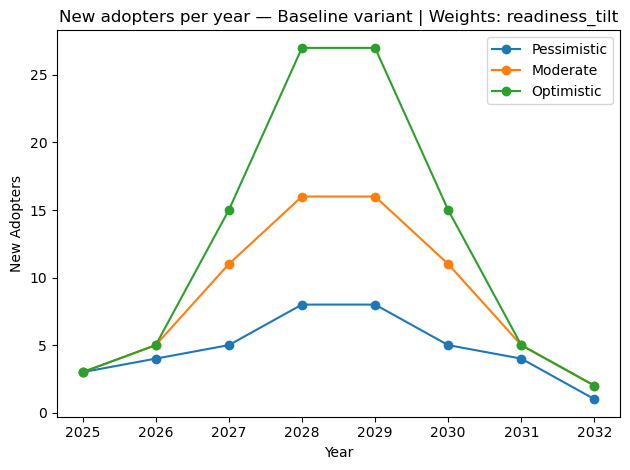

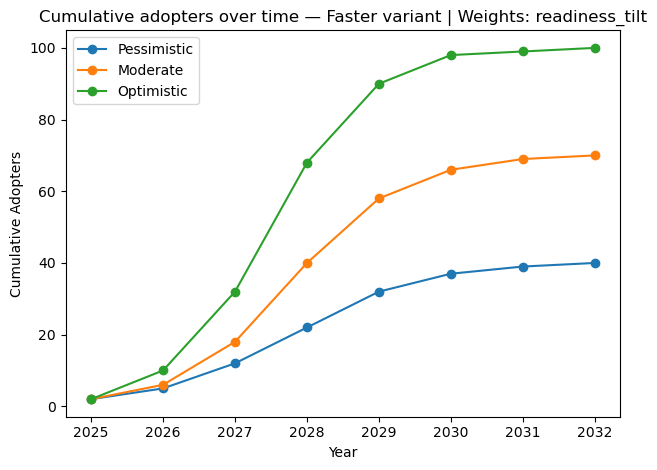

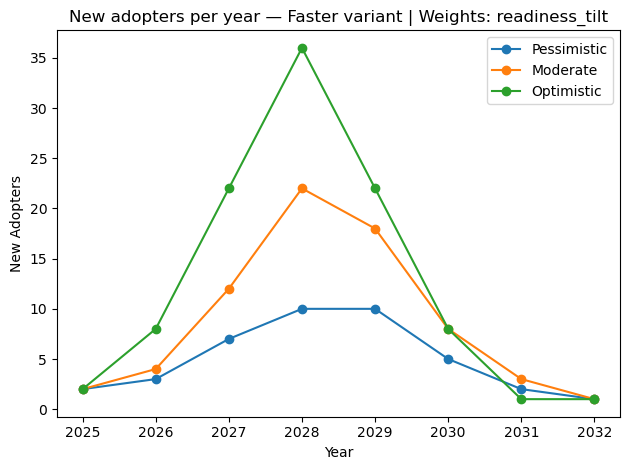

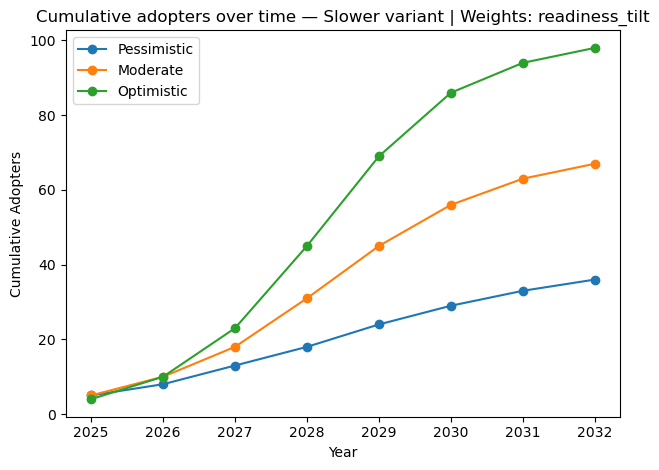

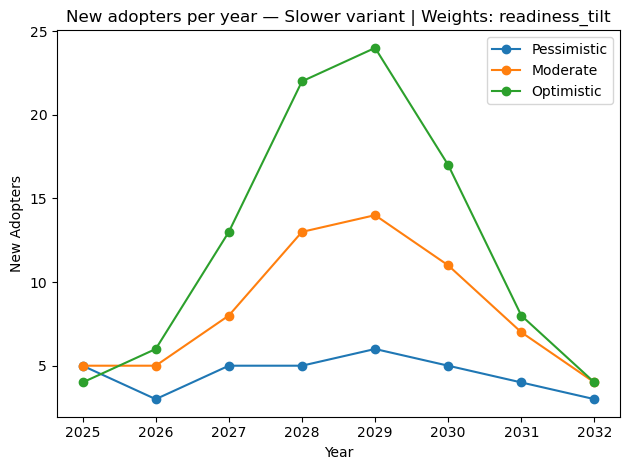

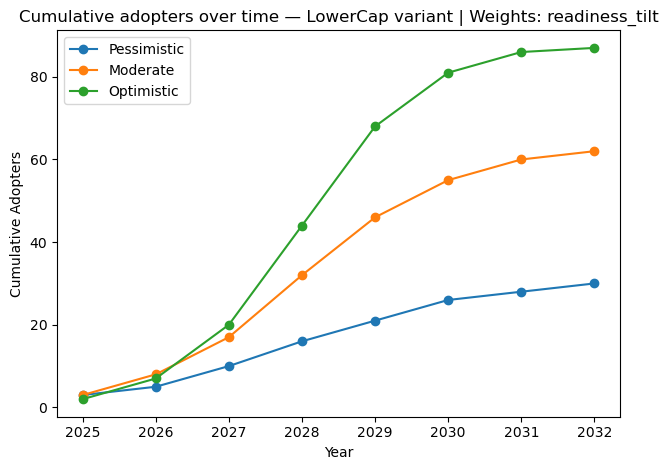

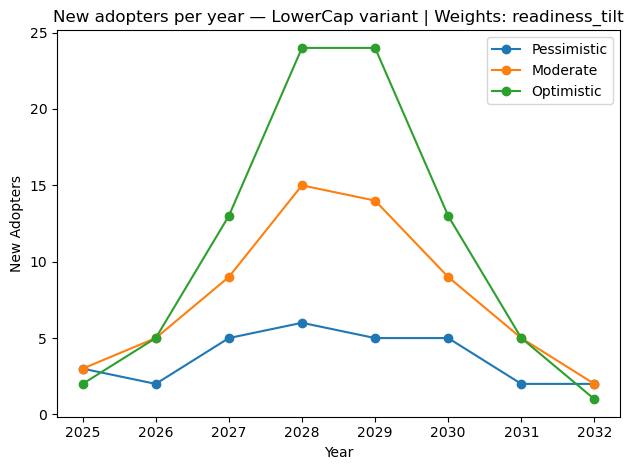

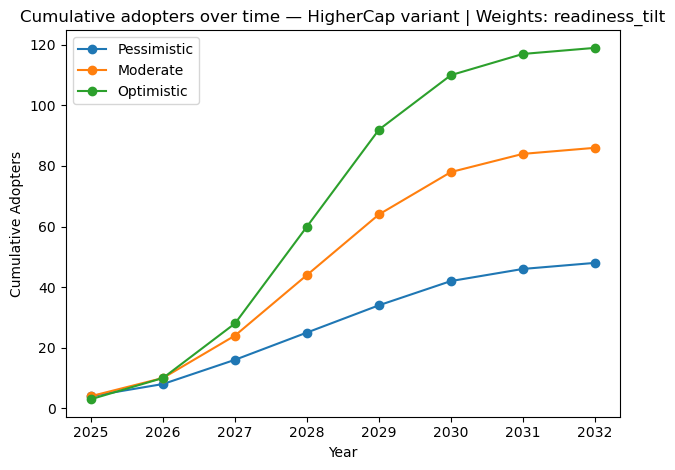

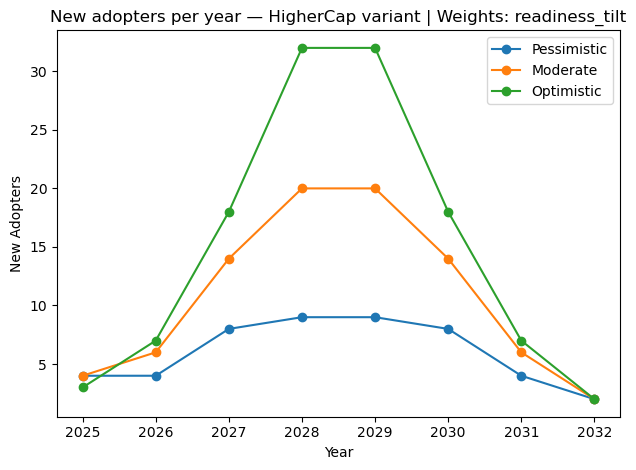

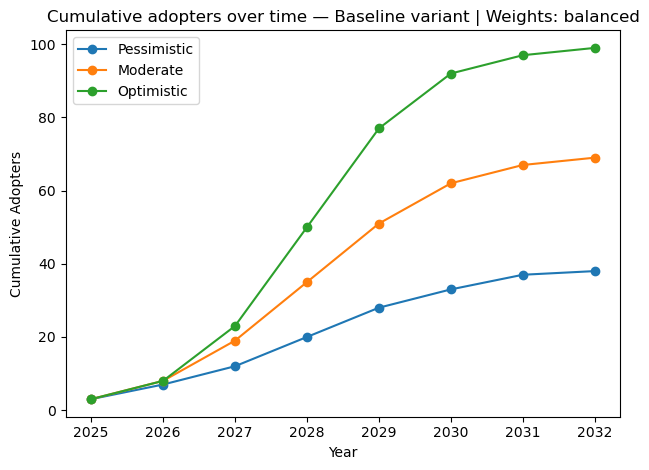

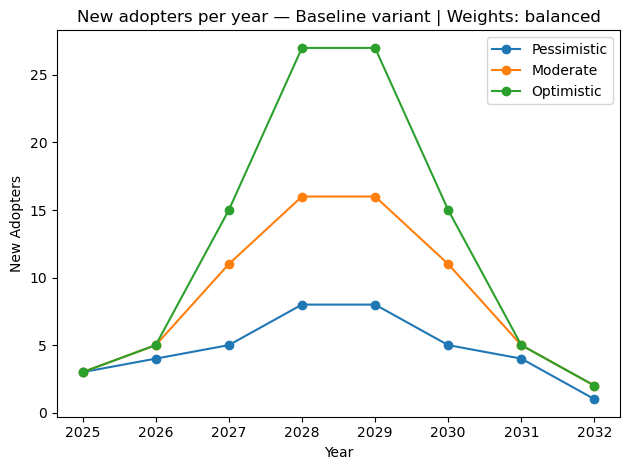

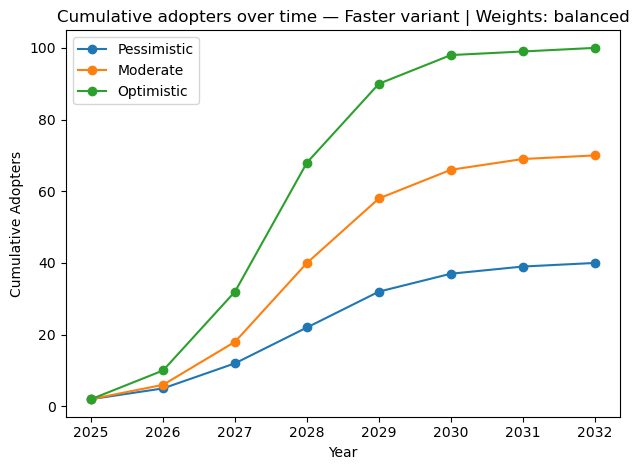

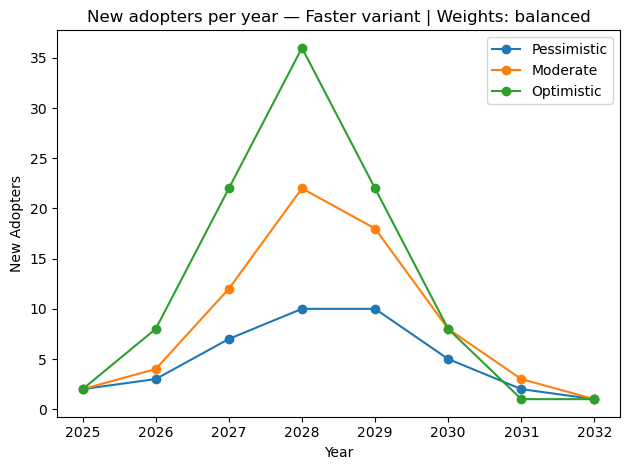

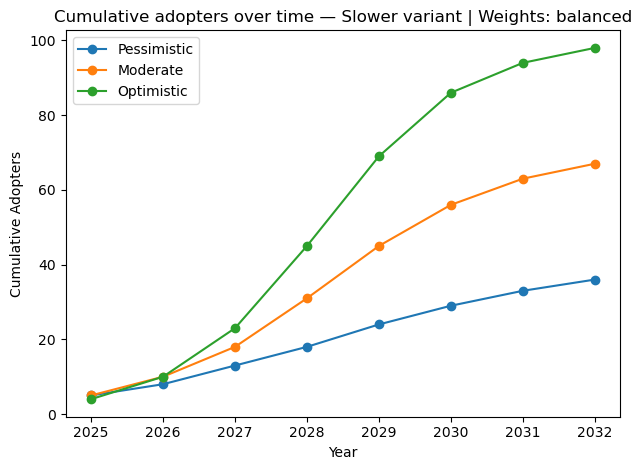

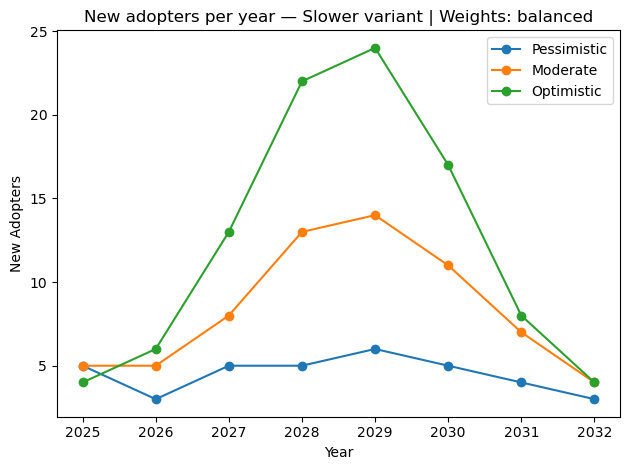

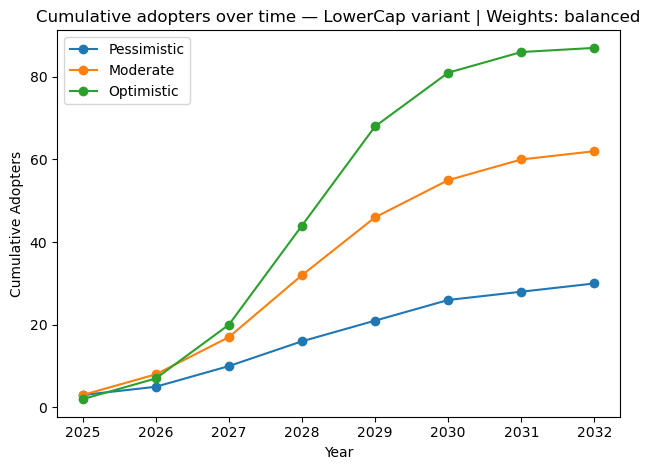

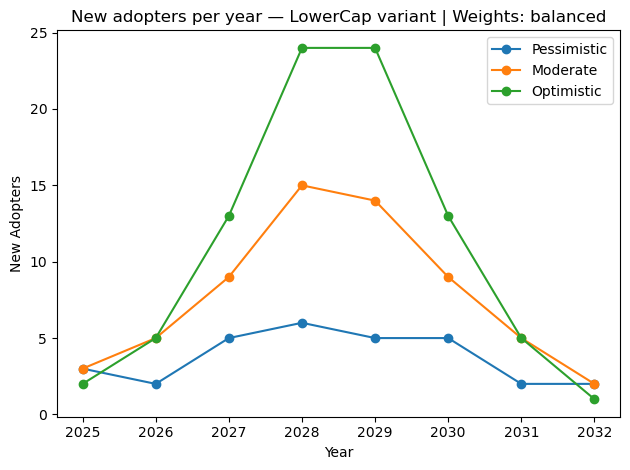

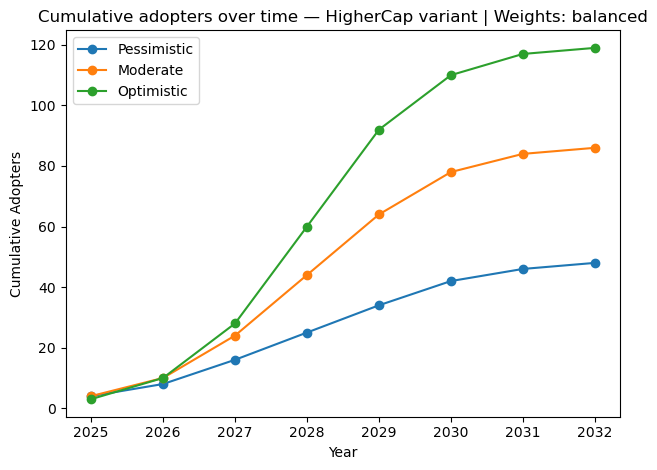

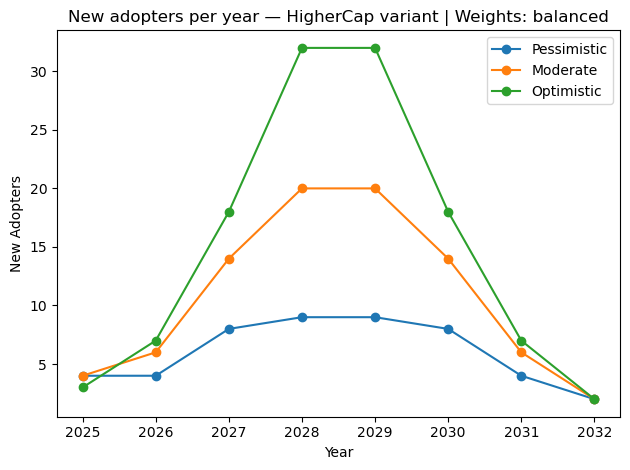

[PLOTS] Created per weight set and variant in: C:\Users\PAVILION\OneDrive - Queen Mary, University of London\Quibim\FINAL_CODES\ADOPTION\outputs


In [ ]:

# Plots for ALL weight sets & variants


import matplotlib.pyplot as plt

# Keep line order consistent
scenario_order = ["Pessimistic", "Moderate", "Optimistic"]

# Which scenario variants to plot? (use all by default)
variants_to_plot = list(schedules_all["Scenario_Variant"].unique())
# If you only want the Baseline variant, uncomment:
# variants_to_plot = ["Baseline"]

for wset in schedules_all["Weights_Set"].unique():
    for variant in variants_to_plot:
        sub = schedules_all[
            (schedules_all["Weights_Set"] == wset) &
            (schedules_all["Scenario_Variant"] == variant)
        ].copy()
        if sub.empty:
            continue

        # CUMULATIVE adopters 
        plt.figure()
        for scen in scenario_order:
            dfc = sub[sub["Scenario"] == scen]
            if dfc.empty:
                continue
            plt.plot(dfc["Year"], dfc["Cumulative_Adopters"], marker="o", label=scen)
        plt.title(f"Cumulative adopters over time — {variant} variant | Weights: {wset}")
        plt.xlabel("Year"); plt.ylabel("Cumulative Adopters")
        plt.legend(); plt.tight_layout()
        p_cum = OUTDIR / f"cum_adopters_{variant}_{wset}_{TS}.png"
        plt.savefig(p_cum, dpi=150); plt.show()

        # NEW adopters per year 
        plt.figure()
        for scen in scenario_order:
            dfc = sub[sub["Scenario"] == scen]
            if dfc.empty:
                continue
            plt.plot(dfc["Year"], dfc["New_Adopters"], marker="o", label=scen)
        plt.title(f"New adopters per year — {variant} variant | Weights: {wset}")
        plt.xlabel("Year"); plt.ylabel("New Adopters")
        plt.legend(); plt.tight_layout()
        p_new = OUTDIR / f"new_adopters_{variant}_{wset}_{TS}.png"
        plt.savefig(p_new, dpi=150); plt.show()

print("[PLOTS] Created per weight set and variant in:", OUTDIR.resolve())
